### Code for testing the generation of realistic wood samples

Consists of slightly altered code from: https://github.com/fgbossema/line_trajectory_simulations

In [2]:
# imports
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [3]:

def phantom_plank(phantom_size, angle = 0, p = 1, v0 = None, ring_width = 1, y1 = 0.222, y2 = 0.422, gaussian_blurr = 0): 
    '''
    Parameters
    ----------
    t : thickness of the plank (in mm)
    w : width of the plank (in mm) 
    l : length of the plank (in mm)
    vx_00 : x location of the left upper pixel relative to the pith (in mm)
    vy_00 : y location of the left upper pixel relative to the pith (in mm)
    vz_00 : z location of the left upper pixel relative to the pith (in mm)
    To have pith in middle of phantom: 
        v00 = (-1/2*phantom_size[1], 1/2*phantom_size[0],1/2*phantom_size[2])
    angle : tilt of the pith, in radians
    p : pixel size. The default is 1.
    y1 : lowest density value. The default is 0.222.
    y2 : highest density value. The default is 0.422. 
    
    Returns
    -------
    phantom : 3D plank phantom, with tree rings. 

    '''
    #If there are no explicit numbers for a,b,c,d,e, but a period given,
    #calculate the numbers a to e as ratio's of the period. 
    t, l, w = phantom_size
    if v0 is not None: 
        vx_00, vy_00, vz_00 = v0
    else: 
        #vx_00, vy_00, vz_00 = (-phantom_size[2],phantom_size[0]/2,0)
        vx_00, vy_00, vz_00 = (-1/2*phantom_size[1], 1/2*phantom_size[0],1/2*phantom_size[2])
    #period = np.ceil(ring_width/p)
    period = ring_width
    #period>0.5
    a = 0
    b = 0.2#4/10*period
    c = 1/2*period
    d = 1/2*period+0.2#(9/10)*period
    e = period
    
    
    
    m = np.int(np.ceil(t/p))
    n = np.int(np.ceil(w/p))
    o = np.int(np.ceil(l/p))
        
    phantom = np.zeros((m,n,o), dtype = 'float32')
    
    #If the tree is straight, every layer is the same. 
    if angle == 0:
        for i in range(m):
            for j in range(n):
                dist = distance_to_pith(i, j, 0, vx_00,vy_00, 0, 0, p)
                value = truncated_triangle(dist, y1, y2, a, b, c, d, e)
                phantom[i,j,:] = value
    
    #If the tree is at an angle, or the plank is cut at an angle, 
                #every layer is different. 
    else: 
        for i in range(m):
                for j in range(n):
                    for k in range(o):
                        dist = distance_to_pith(i, j, k, vx_00, vy_00, vz_00, angle, p)
                        value = truncated_triangle(dist, y1, y2, a, b, c, d, e)
                        phantom[i,j,k] = value
    
    # plt.imshow(phantom[:,:,0])
    # plt.title("First layer of generated phantom (Before adding G blur)")
    # plt.show()
    if gaussian_blurr>0: 
        for i in np.arange(phantom.shape[2]):
            phantom[:,:,i] = gaussian_filter(phantom[:,:,i],sigma = gaussian_blurr)
    
    return phantom

def distance_to_pith(r, c, lr, vx_00, vy_00, vz_00, angle, p):
    '''

    Parameters
    ----------
    r : rownumber
    c : columnnumber
    lr: layernumber (slice in z-direction, which is along the tree)
    vx_00 : x location of the left upper pixel relative to the pith in mm
    vy_00 : y location of the left upper pixel relative to the pith in mm
    vz_00 : z location of the left upper pixel relative to the pith in mm
    p : pixel size, optional, The default is 1.
    

    Returns
    -------
    distance from pith of tree to pixel

    '''
    vx = vx_00 + p*c
    vy = vy_00 - p*r
    vz = vz_00 - p*lr
    
    return np.sqrt(vx**2 + vy**2) + vz * np.arcsin(angle) 

def truncated_triangle(l, y1, y2, a, b, c, d, e):
    '''
    Parameters
    ----------
    l : distance to pith of tree 
    y1 : lowest function value
    y2 : highest function value
    a : start of period including two tree rings, one year: 
        a denser ring and a less dense ring, start of increasing slope
    b : stop of the increasing slope
    c : start of the decreasing slope
    d : stop of the decreasing slope
    e : end of period

    Returns
    -------
    Value for the pixel in the tree phantom, based on a truncated triangle 
    function. 

    '''
    l_mod = np.mod(l,e-a)
    
    if a <= l_mod  < b: 
        return np.abs((y2-y1)/(b-a)*(l_mod-a)+y1)
    elif b <= l_mod < c:
        return y2
    elif c <= l_mod < d:
        return np.abs(-(y2-y1)/(d-c)*(l_mod-c)+y2)
    elif d <= l_mod < e:
        return y1

### Phantom plank:
------------------
- **phantom_size**: Triple of (thickness, length, width) of wood sample (mm).
- **v0 = vx_00, vy_00, vz_00**: Locations of furthest away pixels from [pith](https://woodcarvingillustrated.com/blog/2017/09/18/anatomy-of-wood/#:~:text=Pith%3A%20At%20the%20very%20center,wood%20that%20include%20the%20pith.).
    - - Default values: (-phantom_size[2],phantom_size[0]/2,0)
- **angle**: Tilt of *pith*.
- **p**: Pixel size (default=1)
- **y1, y2**: Lowest and highest values of attenuation coefficient respectively.
- **ring_width**: The width of concentric tree rings (assuming this is measured in pixels?) default is 1.
- **gaussian_blur**: *blurs* image. default is 0.

#### Determination of parameter values
----------------------
- **phantom_size**:
    - Test data given is 5000x5000 pixels, with each pixel representing 1mm (image is 500mmx500mm). Thickness is somewhat arbitrary. will set parameter as (500, 500, 500) for now.
- **vx_00, vy_00, vz_00**:
    - We want pith in the centre, as we will be examining the entire cross-section: (1/2 length, 1/2 thickness, 1/2 width)
- **angle**: 
    - Assume that log will be perfectly centred for now: 0 rad. (default)
- **y1, y2**: Highest and lowest attenuation coefficients for wood (will just work with 0.222 and 0.422 for now)
- **gaussian_blur**: Pretty arbitrary. Will just see what looks best. When ~ 4 seems to get very blurry. 2.5 seems to best for now.

rest default.

Testing below. Not confused!

In [100]:
# Parameters
phantom_size = (500, 500, 500) # t - y axis , l - z axis (defines slice), w - x axis
v0 = ((-1/2)*phantom_size[1], (1/2)*phantom_size[0],(1/2)*phantom_size[2])
ring_width = 30.0
angle = np.deg2rad(0.0)
pix_size = 1
blur = 5

P = phantom_plank(phantom_size, angle = angle, p = pix_size, ring_width = ring_width, gaussian_blurr=blur)
#.transpose([0,2,1])
print(f"Shape of Phantom data: {P.shape}")

C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

Shape of Phantom data: (500, 500, 500)


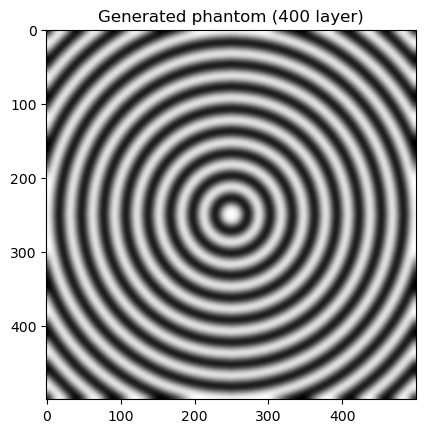

In [101]:
# displaying plank
i = 400
plt.imshow(P[:,:,i], cmap="gray")
plt.title(f"Generated phantom ({i} layer)")
plt.show()
print()

Current assumptions about the phantom size parameter:
- thickness: Represents y-axis in image
- length: represents z-axis, defines current slice
- width: x axis

Seems to follow this, but position of pith changes when dimensions aren't equal? Just easiest to make all dimensions equal.

pix_size:
- Was thinking that increase image size by factor of 10, and increasing pixel size by factor 10 should maintain resolution - does not.
    - Probably due to ring size needing to increase? Yes

#### Testing Image recreation method using paralleltomo

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import imageio

def paralleltomo(*args):
#PARALLELTOMO Creates a 2D tomography system matrix using parallel beams
#
#   [A,theta,p,d] = paralleltomo(N)
#   [A,theta,p,d] = paralleltomo(N,theta)
#   [A,theta,p,d] = paralleltomo(N,theta,p)
#   [A,theta,p,d] = paralleltomo(N,theta,p,d)
#
# This function creates a 2D tomography test problem with an N-times-N
# domain, using p parallel rays for each angle in the vector theta.
#
# Input: 
#   N           Scalar denoting the number of discretization intervals in 
#               each dimesion, such that the domain consists of N^2 cells.
#   theta       Vector containing the angles in degrees. Default: theta = 
#               0:1:179.
#   p           Number of parallel rays for each angle. Default: p =
#               round(sqrt(2)*N).
#   d           Scalar denoting the distance from the first ray to the last.
#               Default: d = sqrt(2)*N.
#
# Output:
#   A           Coefficient matrix with N^2 columns and nA*p rows, 
#               where nA is the number of angles, i.e., length(theta).
#   theta       Vector containing the used angles in degrees.
#   p           The number of used rays for each angle.
#   d           The distance between the first and the last ray.
# 
# See also: fanbeamtomo, seismictomo.

#Anders Nymark Christensen, 20180216, DTU Compute
#Revised from the matlab version by:
    
# Jakob Sauer Jørgensen, Maria Saxild-Hansen and Per Christian Hansen,
# October 1, 201r, DTU Compute.

# Reference: A. C. Kak and M. Slaney, Principles of Computerized 
# Tomographic Imaging, SIAM, Philadelphia, 2001.
    

    import numpy as np
    from scipy.sparse import csr_matrix
    
    N = args[0]

        
    # Default value of d.
    if len(args) < 4:
        d = np.sqrt(2)*N
    else:
        d = args[3]
    
    # Default value of the number of rays.
    if len(args) < 3:
        p = int(round(np.sqrt(2)*N))
    else:
        p = args[2]

    # Default value of the angles theta.
    if len(args) < 2:
        theta = np.matrix(np.arange(0.,180.))
    else:
        theta = args[1]


    # Define the number of angles.
    nA = theta.shape[1]

    # The starting values both the x and the y coordinates. 
    x0 = np.matrix(np.linspace(-d/2,d/2,p)).T
    y0 = np.matrix(np.zeros([p,1]))

    # The intersection lines.
    x = np.matrix(np.arange(-N/2,N/2 + 1)).T
    y = np.copy(x)

    # Initialize vectors that contains the row numbers, the column numbers and
    # the values for creating the matrix A effiecently.
    rows = np.matrix(np.zeros([2*N*nA*p,1]))
    cols = np.copy(rows)
    vals = np.copy(rows)
    idxend = 0


    # Loop over the chosen angles.
    for i in range(0,nA):
                
        # All the starting points for the current angle.
        x0theta = np.cos(np.deg2rad(theta[0,i]))*x0-np.sin(np.deg2rad(theta[0,i]))*y0
        y0theta = np.sin(np.deg2rad(theta[0,i]))*x0+np.cos(np.deg2rad(theta[0,i]))*y0
        
        # The direction vector for all the rays corresponding to the current 
        # angle.
        a = -np.sin(np.deg2rad(theta[0,i]))
        b = np.cos(np.deg2rad(theta[0,i]))
        
        # Loop over the rays.
        for j in range(0,p):
            
            # Use the parametrisation of line to get the y-coordinates of
            # intersections with x = k, i.e. x constant.
            tx = (x - x0theta[j,0])/a
            yx = b*tx + y0theta[j,0]
            
            # Use the parametrisation of line to get the x-coordinates of
            # intersections with y = k, i.e. y constant.
            ty = (y - y0theta[j,0])/b
            xy = a*ty + x0theta[j,0]            
            
            # Collect the intersection times and coordinates. 
            t = np.vstack([tx, ty])
            xxy = np.vstack([x, xy])
            yxy = np.vstack([yx, y])
            
            # Sort the coordinates according to intersection time.
            I = np.argsort(t,0)
            xxy = xxy[I]
            yxy = yxy[I]        
            
            # Skip the points outside the box.
            I1 = np.logical_and(np.array(xxy) >= -N/2 , np.array(xxy) <= N/2)
            I2 = np.logical_and(np.array(yxy) >= -N/2 , np.array(yxy) <= N/2)
            I = np.squeeze(np.logical_and(I1,I2))
            #I = (xxy >= -N/2 & xxy <= N/2 & yxy >= -N/2 & yxy <= N/2)
            xxy = np.squeeze(xxy[I])
            yxy = np.squeeze(yxy[I])
            
            # Skip double points.
            I = np.logical_and(abs(np.diff(xxy)) <= 1e-10 , abs(np.diff(yxy)) <= 1e-10)
            if np.not_equal(I.size, 0):
                I = np.concatenate((I, np.matrix([False])), axis=1)
            xxy = xxy[~I]
            yxy = yxy[~I]
#            xxy = np.delete(xxy,I)
#            yxy = np.delete(yxy,I)
            
            # Calculate the length within cell and determines the number of
            # cells which is hit.
            d = np.sqrt(np.power(np.diff(xxy),2) + np.power(np.diff(yxy),2))
            numvals = d.shape[1]
            
            # Store the values inside the box.
            if numvals > 0:
                
                # If the ray is on the boundary of the box in the top or to the
                # right the ray does not by definition lie with in a valid cell.
                if not ((b == 0 and abs(y0theta[j,0] - N/2) < 1e-15) or (a == 0 and abs(x0theta[j,0] - N/2) < 1e-15)):
                    
                    # Calculates the midpoints of the line within the cells.
                    xm = 0.5*(xxy[0,0:-1]+xxy[0,1:]) + N/2
                    ym = 0.5*(yxy[0,0:-1]+yxy[0,1:]) + N/2
                    
                    # Translate the midpoint coordinates to index.
                    col = np.floor(xm)*N + (N - np.floor(ym)) - 1
                    
                    # Create the indices to store the values to vector for
                    # later creation of A matrix.
                    idxstart = idxend
                    idxend = idxstart + numvals
                    idx = np.arange(idxstart,idxend)
                    
                    # Store row numbers, column numbers and values. 
                    rows[idx,0] = i*p + j
                    cols[idx,0] = col[0,:]
                    vals[idx,0] = d  


    # Truncate excess zeros.
    rows = rows[0:idxend]
    cols = cols[0:idxend]
    vals = vals[0:idxend]
    
    # Create sparse matrix A from the stored values.
    A = csr_matrix((vals[:,0].astype(np.float), (np.squeeze(np.array(rows[:,0]).astype(int)), np.squeeze(np.array(cols[:,0]).astype(int)))), dtype=np.float, shape=(p*nA, N**2)).toarray()

    
    return [A,theta,p,d]

original_im = P[:,0,:]

# Set up with standard parameters
N, p, theta = 75, 175,  np.matrix(np.arange(0.,180., 2))
A = paralleltomo(N, theta, p)[0]

print(f"Shape of original image: {original_im.shape}")

# Resizing image to 75x75
# 500 -> 75 (factor of 75/500 = 3/20)
new_size = 75
old_size = 500
factor = new_size/old_size
print(f"Downscaling factor: {factor}")
resized_im_1 = zoom(original_im, (factor,factor), order=1, mode = "grid-constant")
# resized_im_2 = zoom(original_im, (factor,factor), order=2, mode = "grid-constant")
# resized_im_3 = zoom(original_im, (factor,factor), order=3, mode = "grid-constant")

print(f"Shape of resized image: {resized_im_1.shape}")

x = np.ravel(resized_im_1)

print(f"Shape of unravelled resized image: {x.shape}")
print(f"Shape of A: {A.shape}")

C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide


Shape of original image: (500, 500)
Downscaling factor: 0.15
Shape of resized image: (75, 75)
Shape of unravelled resized image: (5625,)
Shape of A: (15750, 5625)


C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:179: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Comparing original image to resized images

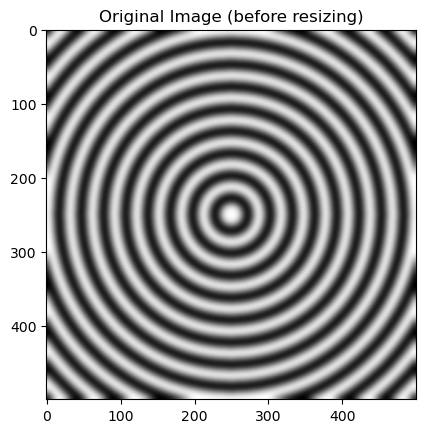

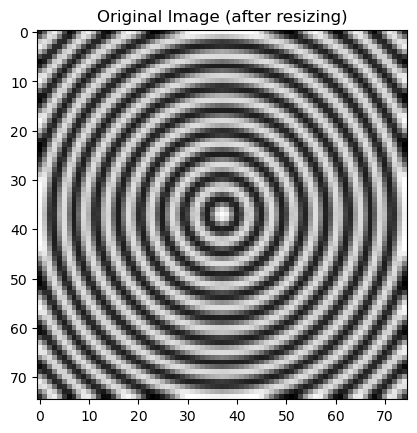

In [56]:
# Comparing images
plt.imshow(original_im, cmap="gray")
plt.title("Original Image (before resizing)")
plt.show()
plt.imshow(resized_im_1, cmap="gray")
plt.title("Original Image (after resizing)")
plt.show()
# plt.imshow(resized_im_2)
# plt.title("Original Image (after resizing)")
# plt.show()
# plt.imshow(resized_im_3)
# plt.title("Original Image (after resizing)")
# plt.show()

In [36]:
# Recreating image
b = np.matmul(A, x)
x_recreated = np.linalg.lstsq(A, b)

# resizing
recreated_im = np.reshape(x, (75,75))

C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


Comparing Original, resized and recreated images

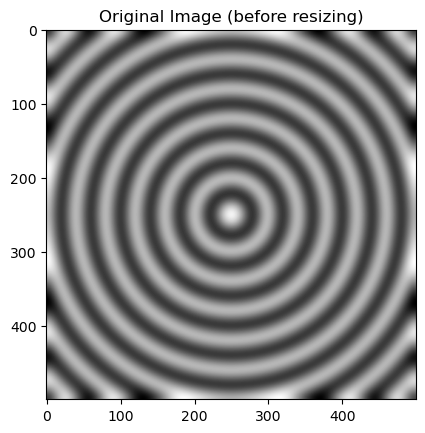

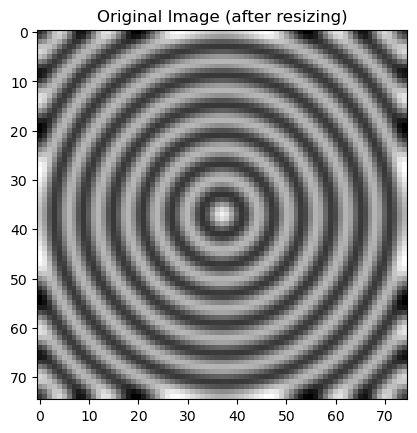

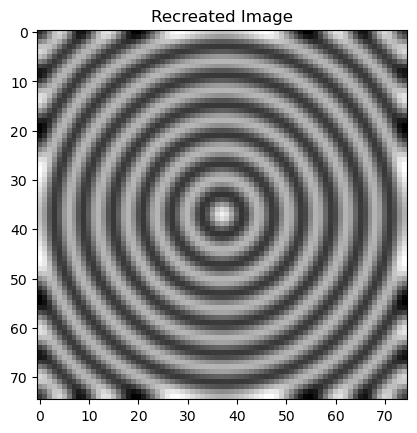

In [37]:
# Comparing Images
plt.imshow(original_im, cmap="gray")
plt.title("Original Image (before resizing)")
plt.show()

plt.imshow(resized_im_1, cmap="gray")
plt.title("Original Image (after resizing)")
plt.show()

plt.imshow(recreated_im, cmap="gray")
plt.title("Recreated Image")
plt.show()

#### Adding shots to image

- Shots are defined as 2mm x 2mm in report
    - Will work with these dimensions.
- Since pixels are defined as 1mm x 1mm in original image, shots will be of dimension 2x2.
- Will begin with lead shot (higher attenuation coefficient - should be easier to detect)

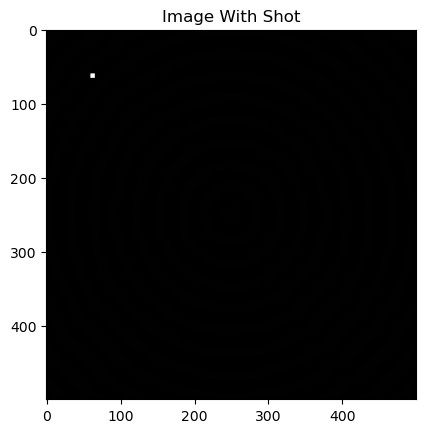

In [60]:
# Defining shot dimensions
lead_AC = 30.3

image_with_shot = original_im
image_with_shot[60:66:1, 60:66:1] = lead_AC


def convert_to_gs(im):
    ac2gs = lambda x: (x/30.2)*255
    cFunc = np.vectorize(ac2gs)
    return cFunc(im)



plt.imshow(image_with_shot, cmap="gray")
plt.title("Image With Shot")
plt.show()

# image_with_shot_gs = convert_to_gs(image_with_shot)
# plt.imshow(image_with_shot_gs)
# plt.title("Image With Shot (converted to grayscale)")
# plt.show()
# image_with_shot_gs

Trying with heatmap

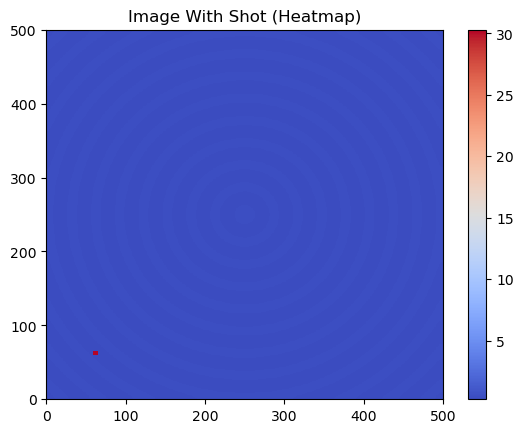

In [61]:
heatmap = plt.pcolor(image_with_shot, cmap="coolwarm")
plt.colorbar(heatmap)
plt.title("Image With Shot (Heatmap)")
plt.show()